In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

from xgboost import XGBClassifier

uploaded = files.upload()
fname = list(uploaded.keys())[0]

Saving amazon_cells_labelled.txt to amazon_cells_labelled.txt


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[fname]), sep='\t')
print(df.shape)
display(df.head())

print("\nPercentual:")
print(df['target'].value_counts(normalize=True)*100)

(1001, 2)


,text,target
0,text,target
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
3,Great for the jawbone.,1
4,Tied to charger for conversations lasting more...,0



Percentual:
target
0         49.95005
1         49.95005
target     0.09990
Name: proportion, dtype: float64


In [ ]:
df.shape

(1001, 2)

In [ ]:
df = df.iloc[1:].copy()

df['target'] = pd.to_numeric(df['target'])

X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamanhos -> treino: {X_train.shape[0]} | teste: {X_test.shape[0]}")

Tamanhos -> treino: 750 | teste: 250


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensão TF-IDF (treino):", X_train_tfidf.shape)

Dimensão TF-IDF (treino): (750, 1366)


In [ ]:
lr_model = LogisticRegression(
    C=2,
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.3,
    max_iter=3000,
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [ ]:
lr_model.fit(X_train_tfidf, y_train)
xgb_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:50:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_tfidf)
y_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    print(f"== {nome} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (AP): {ap:.4f}\n")

avaliar_modelo("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
avaliar_modelo("XGBoost", y_test, y_pred_xgb, y_proba_xgb)

== Logistic Regression ==
Acurácia: 0.8200
Precisão: 0.8636
Recall: 0.7600
F1: 0.8085
AUC-ROC: 0.8992
AUC-PR (AP): 0.9111

== XGBoost ==
Acurácia: 0.7200
Precisão: 0.7477
Recall: 0.6640
F1: 0.7034
AUC-ROC: 0.8047
AUC-PR (AP): 0.8320



In [ ]:
positive_class_index = 1

probs_lr = lr_model.predict_proba(X_test_tfidf)
probs_xgb = xgb_model.predict_proba(X_test_tfidf)

positive_probs_lr = probs_lr[:,1]
positive_probs_xgb = probs_xgb[:,1]

In [ ]:
print(probs_lr)

[[0.77586682 0.22413318]
 [0.51102997 0.48897003]
 [0.71654564 0.28345436]
 [0.57768787 0.42231213]
 [0.68110008 0.31889992]
 [0.68249696 0.31750304]
 [0.4842808  0.5157192 ]
 [0.45068026 0.54931974]
 [0.28023993 0.71976007]
 [0.75478171 0.24521829]
 [0.69922364 0.30077636]
 [0.40184223 0.59815777]
 [0.67902444 0.32097556]
 [0.74193183 0.25806817]
 [0.05158764 0.94841236]
 [0.50632893 0.49367107]
 [0.24346838 0.75653162]
 [0.62472957 0.37527043]
 [0.56170905 0.43829095]
 [0.84358722 0.15641278]
 [0.36939773 0.63060227]
 [0.39477524 0.60522476]
 [0.20277067 0.79722933]
 [0.5541579  0.4458421 ]
 [0.5422972  0.4577028 ]
 [0.36524551 0.63475449]
 [0.70423481 0.29576519]
 [0.37996811 0.62003189]
 [0.56390371 0.43609629]
 [0.04280724 0.95719276]
 [0.34340002 0.65659998]
 [0.78012908 0.21987092]
 [0.23766037 0.76233963]
 [0.43706653 0.56293347]
 [0.84838824 0.15161176]
 [0.57901629 0.42098371]
 [0.33302162 0.66697838]
 [0.09518771 0.90481229]
 [0.13624956 0.86375044]
 [0.46680459 0.53319541]


In [ ]:
print(probs_xgb)

[[4.09955502e-01 5.90044498e-01]
 [8.24880540e-01 1.75119445e-01]
 [5.96397281e-01 4.03602719e-01]
 [7.26120710e-01 2.73879319e-01]
 [9.44463968e-01 5.55360578e-02]
 [9.37433243e-01 6.25667498e-02]
 [4.86444354e-01 5.13555646e-01]
 [3.56487632e-02 9.64351237e-01]
 [6.86774254e-02 9.31322575e-01]
 [3.62973928e-01 6.37026072e-01]
 [5.98893583e-01 4.01106417e-01]
 [1.40397608e-01 8.59602392e-01]
 [7.76936710e-01 2.23063290e-01]
 [9.92514968e-01 7.48504652e-03]
 [8.98790359e-03 9.91012096e-01]
 [7.33576536e-01 2.66423494e-01]
 [5.09350896e-02 9.49064910e-01]
 [9.24832880e-01 7.51671344e-02]
 [3.18971574e-01 6.81028426e-01]
 [9.60399389e-01 3.96005921e-02]
 [1.87966883e-01 8.12033117e-01]
 [4.46853518e-01 5.53146482e-01]
 [2.39910543e-01 7.60089457e-01]
 [5.65732777e-01 4.34267223e-01]
 [4.41529870e-01 5.58470130e-01]
 [3.62973928e-01 6.37026072e-01]
 [9.46362436e-01 5.36375605e-02]
 [7.41257131e-01 2.58742869e-01]
 [4.23989177e-01 5.76010823e-01]
 [8.23575258e-03 9.91764247e-01]
 [1.518190

In [ ]:
df_pos_lr = pd.DataFrame({"prob_spam": positive_probs_lr,"target":y_test})
df_pos_xgb = pd.DataFrame({"prob_spam": positive_probs_xgb,"target":y_test})

In [ ]:
df_pos_lr

,prob_spam,target
437,0.224133,0
407,0.488970,0
219,0.283454,0
350,0.422312,0
29,0.318900,0
...,...,...
366,0.662137,1
220,0.580851,1
646,0.303625,0
103,0.574807,1


In [ ]:
df_pos_xgb

,prob_spam,target
437,0.590044,0
407,0.175119,0
219,0.403603,0
350,0.273879,0
29,0.055536,0
...,...,...
366,0.355544,1
220,0.694051,1
646,0.220973,0
103,0.355544,1


In [ ]:
df_apenas_positivo_lr = df_pos_lr.loc[df_pos_lr['target']==1]
df_apenas_positivo_xgb = df_pos_xgb.loc[df_pos_xgb['target']==1]

In [ ]:
df_apenas_positivo_lr

,prob_spam,target
197,0.515719,1
964,0.719760,1
734,0.598158,1
137,0.948412,1
426,0.756532,1
...,...,...
797,0.420984,1
366,0.662137,1
220,0.580851,1
103,0.574807,1


In [ ]:
df_apenas_positivo_xgb

,prob_spam,target
197,0.513556,1
964,0.931323,1
734,0.859602,1
137,0.991012,1
426,0.949065,1
...,...,...
797,0.355544,1
366,0.355544,1
220,0.694051,1
103,0.355544,1


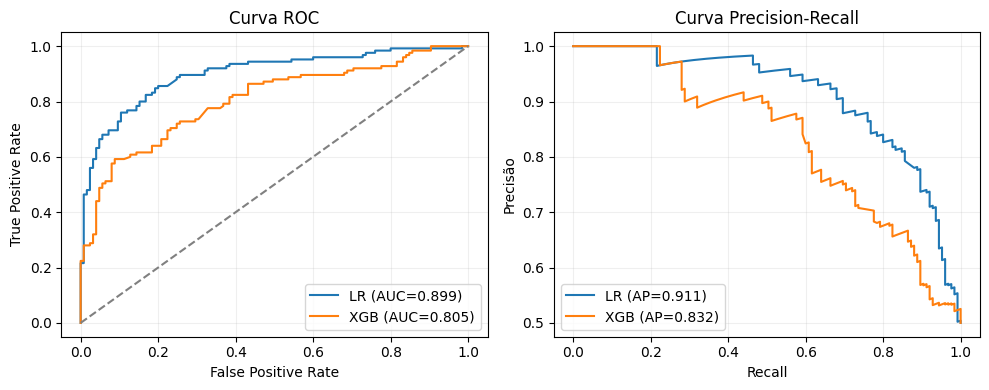

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test, y_proba_lr):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.plot(rec_lr, prec_lr, label=f"LR (AP={average_precision_score(y_test, y_proba_lr):.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP={average_precision_score(y_test, y_proba_xgb):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

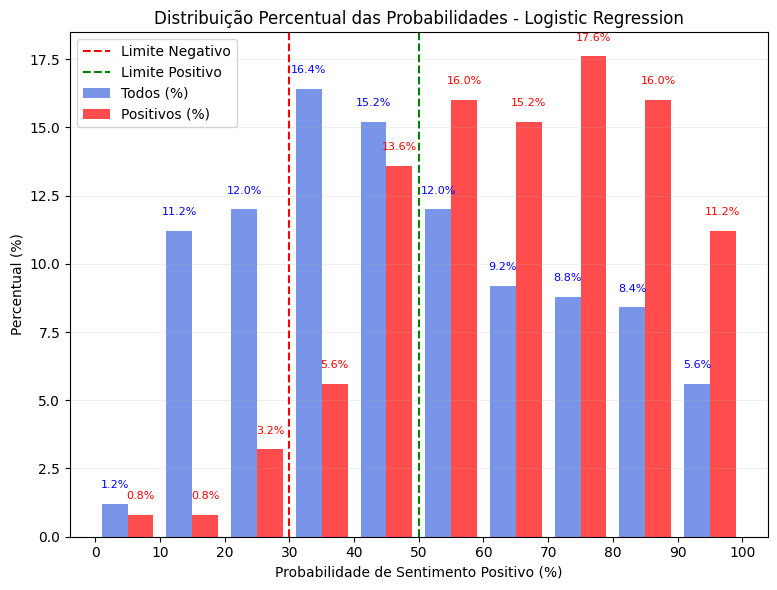

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

step = 0.1
bins = np.arange(0, 1 + step, step)
threshold_neg = 0.3
threshold_pos = 0.5

def plot_distribuicao(y_true, y_pred_proba, nome_modelo):
    """
    Cria o gráfico de distribuição percentual das probabilidades
    mostrando TODAS as previsões vs. amostras realmente positivas.
    """
    hist_all, _ = np.histogram(y_pred_proba, bins=bins)
    hist_pos, _ = np.histogram(y_pred_proba[y_true == 1], bins=bins)

    hist_all_pct = (hist_all / hist_all.sum()) * 100
    hist_pos_pct = (hist_pos / hist_pos.sum()) * 100

    x = (bins[:-1] + bins[1:]) / 2
    width = step * 0.4

    plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', alpha=0.7, color='royalblue')
    plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', alpha=0.7, color='red')

    for xi, val in zip(x - width/2, hist_all_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='blue')
    for xi, val in zip(x + width/2, hist_pos_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='red')

    plt.axvline(threshold_neg, color='red', linestyle='--', label='Limite Negativo')
    plt.axvline(threshold_pos, color='green', linestyle='--', label='Limite Positivo')

    plt.xlabel('Probabilidade de Sentimento Positivo (%)')
    plt.ylabel('Percentual (%)')
    plt.title(f'Distribuição Percentual das Probabilidades - {nome_modelo}')
    plt.xticks(np.arange(0, 1.1, 0.1), [f'{int(v*100)}' for v in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(axis='y', alpha=0.2)


plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plot_distribuicao(y_test, y_proba_lr, "Logistic Regression")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def avaliar_com_threshold(nome, y_true, y_proba, threshold=0.5):
    """
    Avalia o modelo usando um ponto de corte (threshold) customizado.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    aucroc = roc_auc_score(y_true, y_proba)
    aucpr = average_precision_score(y_true, y_proba)

    print(f"\n== {nome} com threshold = {threshold} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {aucroc:.4f}")
    print(f"AUC-PR (AP): {aucpr:.4f}")

    return {
        'threshold': threshold,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'aucroc': aucroc,
        'aucpr': aucpr
    }

In [ ]:
for th in [0.3, 0.5]:
    avaliar_com_threshold("Logistic Regression", y_test, y_proba_lr, threshold=th)


== Logistic Regression com threshold = 0.3 ==
Acurácia: 0.6960
Precisão: 0.6296
Recall: 0.9520
F1: 0.7580
AUC-ROC: 0.8992
AUC-PR (AP): 0.9111

== Logistic Regression com threshold = 0.5 ==
Acurácia: 0.8200
Precisão: 0.8636
Recall: 0.7600
F1: 0.8085
AUC-ROC: 0.8992
AUC-PR (AP): 0.9111


# Relatório de Avaliação de Modelos de Classificação de Sentimentos (Amazon Reviews)

## 1. Modelos Treinados
- Logistic Regression  
- XGBoost  

---

## 2. Métricas Obtidas

| Modelo | Acurácia | Precisão | Recall | F1 | AUC-ROC | AUC-PR |
|:--|:--:|:--:|:--:|:--:|:--:|:--:|
| Logistic Regression | **0.820** | **0.864** | **0.760** | **0.809** | **0.899** | **0.911** |
| XGBoost | 0.720 | 0.748 | 0.664 | 0.703 | 0.805 | 0.832 |

---

## 3. Análise dos Resultados

- A **Regressão Logística** apresentou **melhor desempenho geral**, com maior acurácia, precisão e F1-Score.  
- O **AUC-ROC (0.899)** e o **AUC-PR (0.911)** indicam excelente capacidade de distinção entre sentimentos positivos e negativos.  
- O **XGBoost**, embora eficiente, apresentou **menor calibração das probabilidades** e **distribuição mais dispersa** nas predições.  
- As **curvas ROC e PR** confirmam o domínio da Logistic Regression em praticamente todos os limiares.

---

## 4. Conclusão

O modelo **Logistic Regression** é o **mais indicado** para esta base de sentimentos balanceada da Amazon.  
Ele oferece:
- Melhor equilíbrio entre **precisão e recall**;  
- **Probabilidades mais bem calibradas**;  
- **Maior interpretabilidade** e estabilidade.

✅ **Modelo Recomendado:** Logistic Regression
